In [ ]:
import tensorflow as tf
import pandas as pd
import scipy
import seaborn as sns
import os
from tqdm import tqdm
from matplotlib import pyplot 
from sklearn.model_selection import train_test_split
import numpy as np 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,AveragePooling2D
from tensorflow.keras.callbacks import LearningRateScheduler,ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB1, MobileNet,MobileNetV2,NASNetMobile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler, TensorBoard, CSVLogger 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2]:
def create_model(base_model, model_name):
   model = tf.keras.Sequential([base_model,
                                 tf.keras.layers.GlobalAveragePooling2D(),
                                 tf.keras.layers.Dropout(0.2),
                                 tf.keras.layers.Dense(2, activation="softmax")                                     
                                ])
   print(model_name + " Network Architecture:")
   model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
   return model


In [3]:
# Input shape definition
InputShape = (224,224,3) 

# NASNetMobile base model
NasNetBase = NASNetMobile(include_top=False,
                          weights="imagenet",
                          input_shape=InputShape)
NasNetBase.trainable = True  # Allow fine-tuning

# EfficientNetB1 base model
EfficientNetBase = EfficientNetB1(include_top=False,
                                  weights="imagenet",
                                  input_shape=InputShape)
EfficientNetBase.trainable = True  # Allow fine-tuning

# MobileNetV2 base model
MobileNetV2Base = MobileNetV2(include_top=False,
                              weights="imagenet",
                              alpha=1.0,
                              input_shape=InputShape)
MobileNetV2Base.trainable = True  # Allow fine-tuning



9412608/9406464 [==============================] - 4s 0us/step


In [5]:
NasNet = create_model(NasNetBase,'NasNetModel')
EfficientNet = create_model(EfficientNetBase, 'EfficientNet')
MobileNetV2 = create_model(MobileNetV2Base, 'MobileNetV2')

Models = [NasNet,EfficientNet, MobileNetV2]


NasNetModel Network Architecture:
EfficientNet Network Architecture:
MobileNetV2 Network Architecture:


In [11]:
brain_df = pd.read_csv('brain_mri_data.csv')

In [13]:
brain_df

,patient_id,image_path,mask_path,diagnosis
0,TCGA_CS_4941_19960909,C:/Users/aisha/machine learning/lgg-mri-segmen...,C:/Users/aisha/machine learning/lgg-mri-segmen...,0
1,TCGA_CS_4941_19960909,C:/Users/aisha/machine learning/lgg-mri-segmen...,C:/Users/aisha/machine learning/lgg-mri-segmen...,0
2,TCGA_CS_4941_19960909,C:/Users/aisha/machine learning/lgg-mri-segmen...,C:/Users/aisha/machine learning/lgg-mri-segmen...,0
3,TCGA_CS_4941_19960909,C:/Users/aisha/machine learning/lgg-mri-segmen...,C:/Users/aisha/machine learning/lgg-mri-segmen...,0
4,TCGA_CS_4941_19960909,C:/Users/aisha/machine learning/lgg-mri-segmen...,C:/Users/aisha/machine learning/lgg-mri-segmen...,0
...,...,...,...,...
3924,TCGA_HT_A61B_19991127,C:/Users/aisha/machine learning/lgg-mri-segmen...,C:/Users/aisha/machine learning/lgg-mri-segmen...,0
3925,TCGA_HT_A61B_19991127,C:/Users/aisha/machine learning/lgg-mri-segmen...,C:/Users/aisha/machine learning/lgg-mri-segmen...,0
3926,TCGA_HT_A61B_19991127,C:/Users/aisha/machine learning/lgg-mri-segmen...,C:/Users/aisha/machine learning/lgg-mri-segmen...,0
3927,TCGA_HT_A61B_19991127,C:/Users/aisha/machine learning/lgg-mri-segmen...,C:/Users/aisha/machine learning/lgg-mri-segmen...,0


In [15]:
brain_df_train = brain_df.drop(columns=['Unnamed:0', 'patient_id'], axis=1, errors='ignore')
brain_df_train['diagnosis'] = brain_df['diagnosis'].astype(str)
brain_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   diagnosis   3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


In [16]:
train, test = train_test_split(brain_df_train, test_size=0.15)
datagen = ImageDataGenerator(rescale=1./255., validation_split=0.1)

# Training data generator
train_generator = datagen.flow_from_dataframe(train,
                                              directory='./',
                                              x_col='image_path',
                                              y_col='diagnosis',
                                              subset='training',
                                              class_mode='categorical',
                                              batch_size=16,
                                              shuffle=True,
                                              target_size=(224, 224))

# Validation data generator
valid_generator = datagen.flow_from_dataframe(train,
                                              directory='./',
                                              x_col='image_path',
                                              y_col='diagnosis',
                                              subset='validation',
                                              class_mode='categorical',
                                              batch_size=16,
                                              shuffle=True,
                                              target_size=(224, 224))

# Test data generator
test_datagen = ImageDataGenerator(rescale=1./255.)
test_generator = test_datagen.flow_from_dataframe(test,
                                                  directory='./',
                                                  x_col='image_path',
                                                  y_col='diagnosis',
                                                  class_mode='categorical',
                                                  batch_size=16,
                                                  shuffle=False,
                                                  target_size=(224, 224))


Found 3006 validated image filenames belonging to 2 classes.
Found 333 validated image filenames belonging to 2 classes.
Found 590 validated image filenames belonging to 2 classes.


In [31]:
# Early stopping to avoid overfitting
earlystopping = EarlyStopping(monitor='val_loss', 
                              mode='min', 
                              verbose=1, 
                              patience=15)

# Saving the best model weights
checkpointer = ModelCheckpoint(filepath="ensemble-weights_{epoch:02d}-{val_loss:.2f}.hdf5",
                               verbose=1, 
                               save_best_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                               mode='min',
                               verbose=1,
                               patience=10, 
                               min_delta=0.0001,
                               factor=0.2)

# TensorBoard for visualization
tensorboard = TensorBoard(log_dir='logs', 
                          histogram_freq=1,
                          write_graph=True,
                          write_images=True)

callbacks = [checkpointer, earlystopping, reduce_lr, tensorboard, csv_logger]


In [32]:
num_epochs = 10

TrainedModels = []  
histories = []      

for model in tqdm(Models, desc="Training Models"):
    try:
        # Fit the model
        history = model.fit(
            train_generator,
            steps_per_epoch=train_generator.n // train_generator.batch_size,
            epochs=num_epochs,
            validation_data=valid_generator,
            validation_steps=valid_generator.n // valid_generator.batch_size,
            callbacks=[checkpointer, earlystopping]
        )
        
        TrainedModels.append(model)
        histories.append(history.history)  
        
    except Exception as e:
        print(f"An error occurred while training {model.name}: {e}")


Training Models:   0%|                                                                           | 0/3 [00:00<?, ?it/s]

Epoch 1/10
187/187 [==============================] - ETA: 0s - loss: 0.0560 - accuracy: 0.9799
Epoch 00001: val_loss improved from inf to 14.42306, saving model to ensemble-weights_01-14.42.hdf5
187/187 [==============================] - 498s 3s/step - loss: 0.0560 - accuracy: 0.9799 - val_loss: 14.4231 - val_accuracy: 0.8313
Epoch 2/10
187/187 [==============================] - ETA: 0s - loss: 0.0311 - accuracy: 0.9903
Epoch 00002: val_loss improved from 14.42306 to 8.22198, saving model to ensemble-weights_02-8.22.hdf5
187/187 [==============================] - 576s 3s/step - loss: 0.0311 - accuracy: 0.9903 - val_loss: 8.2220 - val_accuracy: 0.8062
Epoch 3/10
187/187 [==============================] - ETA: 0s - loss: 0.0428 - accuracy: 0.9873
Epoch 00003: val_loss improved from 8.22198 to 2.43436, saving model to ensemble-weights_03-2.43.hdf5
187/187 [==============================] - 523s 3s/step - loss: 0.0428 - accuracy: 0.9873 - val_loss: 2.4344 - val_accuracy: 0.8813
Epoch 4/10

Training Models:  33%|████████████████████▎                                        | 1/3 [1:37:34<3:15:09, 5854.57s/it]

Epoch 1/10
187/187 [==============================] - ETA: 0s - loss: 0.0080 - accuracy: 0.9970
Epoch 00001: val_loss improved from 2.43436 to 0.55438, saving model to ensemble-weights_01-0.55.hdf5
187/187 [==============================] - 1040s 6s/step - loss: 0.0080 - accuracy: 0.9970 - val_loss: 0.5544 - val_accuracy: 0.8562
Epoch 2/10
187/187 [==============================] - ETA: 0s - loss: 0.0112 - accuracy: 0.9960
Epoch 00002: val_loss did not improve from 0.55438
187/187 [==============================] - 1028s 5s/step - loss: 0.0112 - accuracy: 0.9960 - val_loss: 5.2652 - val_accuracy: 0.6594
Epoch 3/10
187/187 [==============================] - ETA: 0s - loss: 0.0063 - accuracy: 0.9980
Epoch 00003: val_loss did not improve from 0.55438
187/187 [==============================] - 1034s 6s/step - loss: 0.0063 - accuracy: 0.9980 - val_loss: 2.1513 - val_accuracy: 0.7375
Epoch 4/10
187/187 [==============================] - ETA: 0s - loss: 0.0125 - accuracy: 0.9963
Epoch 00004: 

Training Models:  67%|████████████████████████████████████████▋                    | 2/3 [5:00:08<2:39:20, 9560.06s/it]

Epoch 1/10
187/187 [==============================] - ETA: 0s - loss: 0.0271 - accuracy: 0.9910
Epoch 00001: val_loss did not improve from 0.55438
187/187 [==============================] - 471s 3s/step - loss: 0.0271 - accuracy: 0.9910 - val_loss: 0.9415 - val_accuracy: 0.8719
Epoch 2/10
187/187 [==============================] - ETA: 0s - loss: 0.0343 - accuracy: 0.9916
Epoch 00002: val_loss did not improve from 0.55438
187/187 [==============================] - 471s 3s/step - loss: 0.0343 - accuracy: 0.9916 - val_loss: 1.1494 - val_accuracy: 0.8250
Epoch 3/10
187/187 [==============================] - ETA: 0s - loss: 0.0272 - accuracy: 0.9913
Epoch 00003: val_loss did not improve from 0.55438
187/187 [==============================] - 473s 3s/step - loss: 0.0272 - accuracy: 0.9913 - val_loss: 0.8266 - val_accuracy: 0.8500
Epoch 4/10
187/187 [==============================] - ETA: 0s - loss: 0.0132 - accuracy: 0.9950
Epoch 00004: val_loss did not improve from 0.55438
187/187 [=======

Training Models: 100%|███████████████████████████████████████████████████████████████| 3/3 [6:14:16<00:00, 7485.53s/it]


In [33]:
labels = []
for m in TrainedModels:
    predicts = np.argmax(m.predict(test_generator), axis=1)
    labels.append(predicts)

# Ensemble with voting
labels = np.array(labels)
labels = np.transpose(labels, (1, 0))
print(labels)

[[1 0 1]
 [0 0 0]
 [0 0 1]
 ...
 [1 0 1]
 [1 0 1]
 [0 0 0]]


In [34]:
labls = scipy.stats.mode(labels,axis=1, keepdims=False)[0]
labls = np.squeeze(labls)

original = np.asarray(test['diagnosis']).astype('int')  
print (labls)

[1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 1 0 1 1 1 0 0 1 0 0 0 0 0 1 1 0 0 0
 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 0 1 0 0 1 1 0 1 0 0 1 1 0 0 1 0 0 0 0 0 0
 0 1 0 0 0 0 1 1 1 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 1 1 0 1 0 0 1 0 0 0 0 1
 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 1 1 0 0 0 1 1 1 0 1 1 1 1
 0 1 0 0 1 0 1 0 1 0 1 0 0 0 0 1 0 1 0 0 1 1 1 1 1 1 1 0 0 0 1 1 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 1 0 0 1 0 0 0 0 1 0 1 0 1 0 1 1
 1 0 1 1 0 0 1 1 1 0 0 0 1 0 0 0 1 0 0 1 0 0 1 1 0 0 1 0 0 0 0 0 0 1 0 0 0
 1 1 1 1 0 0 0 0 1 0 0 1 0 1 0 0 1 0 0 1 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 1 1
 0 1 0 1 0 0 1 1 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 1 1 0 1 0 1 1 0
 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 1 0 1 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0
 0 0 0 1 0 0 0 1 0 1 0 1 0 0 1 0 0 1 1 1 0 0 0 0 0 0 0 1 0 0 0 1 1 0 1 1 1
 1 0 1 0 0 1 1 0 0 1 1 0 0 0 0 1 0 0 0 1 0 0 1 0 1 0 0 1 1 0 0 0 0 0 1 0 1
 0 0 0 0 1 1 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 1 0
 1 0 1 0 0 1 1 0 0 0 0 0 

0.9440677966101695
              precision    recall  f1-score   support

           0       0.96      0.95      0.96       387
           1       0.91      0.93      0.92       203

    accuracy                           0.94       590
   macro avg       0.94      0.94      0.94       590
weighted avg       0.94      0.94      0.94       590



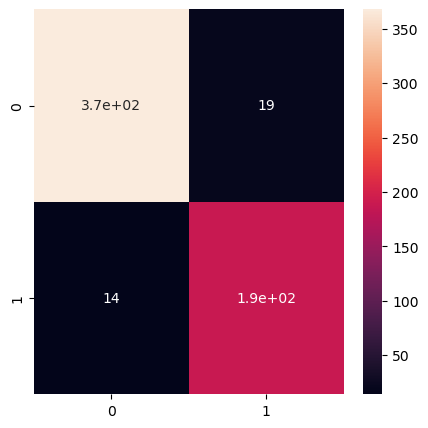

In [35]:
pred = labls
accuracy = accuracy_score(original, pred)
print(accuracy)

cm = confusion_matrix(original, pred)

report = classification_report(original, pred, labels = [0,1])
print(report)
pyplot.figure(figsize = (5,5))
sns.heatmap(cm, annot=True);

In [39]:
TrainedModels[0].save('firstModel')
TrainedModels[1].save('secondModel')
TrainedModels[2].save('thirdModel')

INFO:tensorflow:Assets written to: firstModel\assets
INFO:tensorflow:Assets written to: secondModel\assets
INFO:tensorflow:Assets written to: thirdModel\assets
